In [2900]:
%matplotlib inline
import xgboost as xgb  
import matplotlib.pyplot as plt  
import seaborn as sns
plt.rcParams["figure.figsize"] = (11, 11)  #set default figure size
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error,r2_score
import matplotlib.pylab as plt
from sklearn.model_selection import GridSearchCV, cross_val_score

In [2901]:
df = pd.read_csv('MP_data_0323_TN.csv', index_col=None, engine='c')
print('original datasize:', df.shape)
df.dropna(inplace=True)
print('adjusted datasize:', df.shape)
print('data:')
print(df.head())

xx= df.iloc[:,0:-1]  # 特征 
yy=df.iloc[:,-1]   # 目标变量

zscore = StandardScaler()   #用于数据标准化处理的缩放器
scaler =MinMaxScaler()   #用于数据最小最大缩放处理的缩放器
xx_scaled = zscore.fit_transform(xx)  
yy_scaled = scaler.fit_transform(np.reshape(yy.values,(len(yy),1))) 


def split(xx, yy):  #定义一个函数用来划分训练集，测试集，验证集

    x_train, x_test_val, y_train, y_test_val = train_test_split(xx_scaled, yy_scaled, shuffle=True, test_size=0.3, random_state=1)
    #x_训练集，x_测试验证集，y_训练集，y_测试验证集                    划分前将数据集进行随机打乱，并按照6：4划分，且划分方式统一
    x_test, x_val, y_test, y_val = train_test_split(x_test_val, y_test_val, shuffle=True, test_size=0.25,
                                                    random_state=1)
    #x_测试集，x_验证集，y_测试集，y_验证集                           划分前将数据集进行随机打乱，并按照3：1划分，且划分方式统一

    y2 = yy.ravel()  #将yy数组转化为一维数组并存在y2中
    ind_train = [np.argwhere(y2 == y_train[i])[0].item() for i in range(len(y_train)) if y_train[i] in y2]
    #这是一个循环，遍历y_train中的每一个元素，判断y_train中的当前标签y_train[i]是否存在于y2中
    #找到y2中所有等于y_train[i]的元素的索引，返回一个二维数组，然后用[0].item()取得第一行赋值给ind_train生成列表
    ind_test = [np.argwhere(y2 == y_test[i])[0].item() for i in range(len(y_test)) if y_test[i] in y2]
    ind_val = [np.argwhere(y2 == y_val[i])[0].item() for i in range(len(y_val)) if y_val[i] in y2]

    y_train = y_train.ravel()  #将y_train数组转化为一维数组
    y_test = y_test.ravel()  #将y_text数组转化为一维数组
    y_val = y_val.ravel()  #将y_val数组转化为一维数组

    return x_train, x_test, x_val, y_train, y_test, y_val, xx, yy, np.asarray(ind_train), np.asarray(
        ind_train), np.asarray(ind_val)
    #返回训练集，测试集，验证集的特征数据，和标签（目标变量）数据，原特数据，原目标变量数据，以及转化为数组的ind_train，ind_train，ind_val



x_train, x_test, x_val, y_train, y_test, y_val, x_scaled, y_scaled, ind_train, ind_test, ind_val = split(xx_scaled, yy_scaled)

print('目标变量是 ', yy.name)
print('特征变量是 ', xx.columns.tolist())
print('样本大小 is ', xx.shape[0], '; 特征变量的数量 is ', xx.shape[1])
print('训练集数据大小 is ', x_train.shape[0], '; 测试集数据大小 is ', x_test.shape[0], '; 验证集数据大小 is ',
      x_val.shape[0])

original datasize: (222, 17)
adjusted datasize: (222, 17)
data:
   Time  Deep  Length   HRT     COD    TN  NH4-N    C/N    c(A)  CSC  XLogP3  \
0    90  12.5    45.0  72.0  299.46  26.8  24.07  11.17  100.00   11    -0.1   
1    90  45.0    12.5  72.0  299.46  26.8  24.07  11.17  100.00   11    -0.1   
2    84  10.0    30.0  72.0   66.60   3.6   2.35  18.50    0.18   11     0.2   
3    84  10.0    90.0  72.0   66.60   3.6   2.35  18.50    0.18   11     0.2   
4    84  50.0    30.0  72.0   66.60   3.6   2.35  18.50    0.18   11     0.2   

    WI    RA(P)   RA(F)    RA(B)   RA(A)  RR(TN)  
0  885  48.0057  1.8966   9.9499  2.3363  0.6451  
1  885  62.3032  1.6632   6.7403  0.9921  0.6451  
2  943  50.8357  0.9988  10.7969  7.0869  0.8028  
3  943  46.2696  1.4269  11.2249  2.6160  0.8028  
4  943  38.7070  0.6659   6.9918  1.5220  0.8028  
目标变量是  RR(TN)
特征变量是  ['Time', 'Deep', 'Length', 'HRT', 'COD', 'TN', 'NH4-N', 'C/N', 'c(A)', 'CSC', 'XLogP3', 'WI', 'RA(P)', 'RA(F)', 'RA(B)', 'RA(A)'

# 定义参数网格，添加gamma, reg_alpha, reg_lambda  
param_grid = {  
    'n_estimators': [500, 1000, 1500],  
    'learning_rate': [0.05, 0.1, 0.15],  
    'subsample': [0.6, 0.7, 0.8],  
    'colsample_bytree': [0.6, 0.7, 0.8],  
    'max_depth': [3, 4, 5],  
    'gamma': [0, 0.25, 1.0],  # 添加gamma参数  
    'reg_alpha': [0, 0.1, 1.0],  # 添加L1正则化项  
    'reg_lambda': [1.0, 1.5, 2.0]  # 添加L2正则化项  
}  
  
# 初始化XGBoost回归模型，不需要在这里设置gamma, reg_alpha, reg_lambda  
xgb_reg = xgb.XGBRegressor(eval_metric='rmse', objective='reg:squarederror')  
  
# 初始化GridSearchCV对象，设置cv为交叉验证的次数，scoring为评价指标（注意这里是neg_mean_squared_error，因为GridSearchCV期望得分越低越好，所以RMSE前面加了个负号）  
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)  
  
# 执行网格搜索  
grid_search.fit(x_train, y_train)  
  
# 获取最佳参数组合  
best_params = grid_search.best_params_  
print("Best parameters found: ", best_params)  
  
# 获取最优模型的RMSE得分  
best_score = np.sqrt(-grid_search.best_score_)  # 转换为正值的RMSE  
print("Best RMSE score: ", best_score)  
  

In [2902]:
xgb = xgb.XGBRegressor(  
    n_estimators=31,  
    learning_rate=0.1,  
    subsample=0.5,  
    colsample_bytree=0.5,   
    max_depth=8,  
    gamma=0,  # 添加gamma参数    
    reg_alpha=1e-5,  # L1正则化项  
    reg_lambda=0,  # L2正则化项  
    eval_metric='rmse'  # 将eval_metric移动到这里  
)  
# 训练模型并指定评估数据集  
eval_set = [(x_train, y_train), (x_test, y_test)]  
xgb.fit(x_train, y_train,  eval_set=eval_set, verbose=False)  

y_pred_train = xgb.predict(x_train)  
y_pred_test = xgb.predict(x_test)  
y_pred_val = xgb.predict(x_val) 

In [2903]:
# 交叉验证得分  
scores = cross_val_score(xgb, x_train, y_train, cv=5)  
print("Mean cross-validation score: %.2f" % scores.mean())  

print('XGB training\tR2:{:.4f}\t\tMSE:{:.6f}\t\tMAE:{:.6f}'.format(xgb.score(x_train,y_train), mean_squared_error(y_train, y_pred_train),
                                                        mean_absolute_error(y_train, y_pred_train)))
print('XGB test  \t\tR2:{:.4f}\t\tMSE:{:.6f}\t\tMAE:{:.6f}'.format(xgb.score(x_test,y_test), mean_squared_error(y_test, y_pred_test),
                                                        mean_absolute_error(y_test, y_pred_test)))

print('XGB valid \t\tR2:{:.4f}\t\tMSE:{:.6f}\t\tMAE:{:.6f}'.format(xgb.score(x_val,y_val), mean_squared_error(y_val, y_pred_val),
                                                        mean_absolute_error(y_val, y_pred_val)))

Mean cross-validation score: 0.85
XGB training	R2:0.9872		MSE:0.001004		MAE:0.023416
XGB test  		R2:0.8440		MSE:0.013452		MAE:0.077308
XGB valid 		R2:0.8377		MSE:0.005633		MAE:0.056097


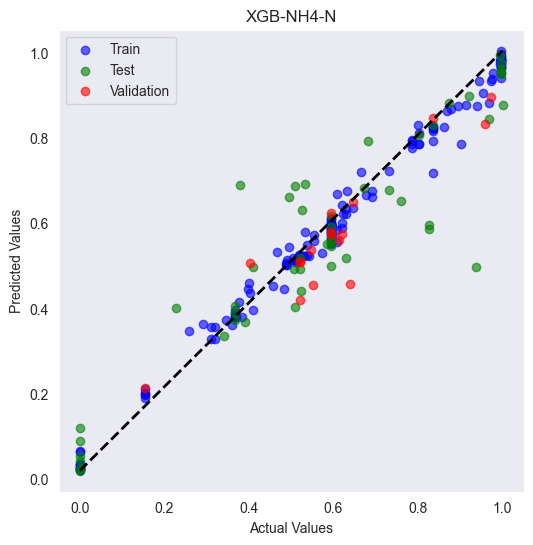

In [2904]:
y_pred_train = xgb.predict(x_train)    
y_pred_test = xgb.predict(x_test)    
y_pred_val = xgb.predict(x_val) 


def scatter_plots(model_name, y_pred_train, y_pred_test,y_pred_val, y_train, y_test, y_val):  
    
    plt.figure(figsize=(6, 6))     # 设置图的大小 
    
    # 在同一个图中绘制所有点的散点图  
    plt.scatter(y_train, y_pred_train, color='blue', label='Train', alpha=0.6)  
                                 #散点的颜色设置为蓝色，标签设置为‘Train’，散点的透明度设置为0.6
    plt.scatter(y_test, y_pred_test, color='green', label='Test', alpha=0.6)  
    plt.scatter(y_val, y_pred_val, color='red', label='Validation', alpha=0.6)  
      
    # 绘制完美拟合线  
    limits = [  
        min(y_train.min(), y_test.min(), y_val.min()),  # x min  
        max(y_train.max(), y_test.max(), y_val.max()),  # x max  
        min(y_pred_train.min(), y_pred_test.min(), y_pred_val.min()),  # y min  
        max(y_pred_train.max(), y_pred_test.max(), y_pred_val.max()),  # y max  
    ]  
    plt.plot(limits[:2], limits[2:], 'k--', lw=2)  
      
    # 设置图的标题和坐标轴标签  
    plt.title('XGB-NH4-N')     #图片标题
    plt.xlabel('Actual Values')     #x轴标题
    plt.ylabel('Predicted Values')      #y轴标题
    # 禁用网格  
    plt.grid(False)
    # 显示图例  
    plt.legend()  
      
    # 显示图形  
    plt.show()  
    
# 调用scatter_plots函数生成图像
scatter_plots('XGB', y_pred_train, y_pred_test, y_pred_val, y_train, y_test, y_val)

sns.set_style("white") 
palette = sns.color_palette("husl", n_colors=2) 
 
# 设置画布大小和分辨率
plt.figure(figsize=(10, 5), dpi=300)
 
# 绘制测试集数据的真实值和模型预测值的折线图
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="True Values", color=palette[0], linewidth=1)
plt.plot(x_ax, predictions, label="Predicted Values", color=palette[1], linewidth=1)
 
# 添加标题和标签
plt.title("PR(TN) - True vs Predicted Values")
plt.xlabel("Sample Number")
plt.ylabel("PR(TN)")
 
# 显示图例
plt.legend()
#plt.savefig('True vs Predicted Values.png')
# 显示图形
plt.show()

In [2905]:
import pickle
# save xgboost model
model_name = 'xgb.pkl' # 模型名称.plk
path =''
with open(path+'xgb.pkl','wb') as f:
    pickle.dump(xgb, f)

In [2906]:
#y_train

In [2907]:
#y_pred_train

In [2908]:
#y_test

In [2909]:
#y_pred_test

In [2910]:
#y_val

In [2911]:
#y_pred_val

#   PDP

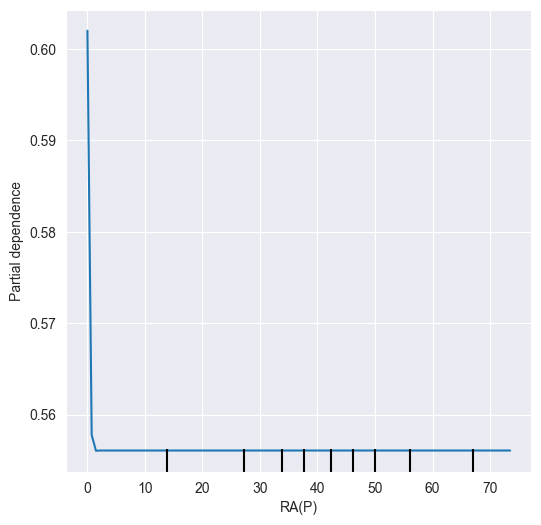

In [2912]:
from matplotlib import pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

x_train, x_test_val, y_train, y_test_val = train_test_split(xx, yy, shuffle=True, test_size=0.3, random_state=1)
#x_训练集，x_测试验证集，y_训练集，y_测试验证集                    划分前将数据集进行随机打乱，并按照7：3划分，且划分方式统一
x_test, x_val, y_test, y_val = train_test_split(x_test_val, y_test_val, shuffle=True, test_size=0.25, random_state=1)
#x_测试集，x_验证集，y_测试集，y_验证集                           划分前将数据集进行随机打乱，并按照3：1划分，且划分方式统一

feature_names = ['Time', 'Deep', 'Length', 'HRT', 'COD', 'TN', 'NH4-N', 'C/N', 'c(A)', 'CSC', 'XLogP3', 'WI', 'RA(P)',
                 'RA(F)', 'RA(B)', 'RA(A)']

feat_name = ('RA(P)')
PartialDependenceDisplay.from_estimator(xgb, x_train, [feat_name])
plt.gcf().set_size_inches(6, 6)  # w 是宽度，h 是高度  
plt.show()

#   ICE

In [2913]:
from pycebox.ice import ice, ice_plot

# 假设您已经训练了随机森林模型，并且准备好特征和目标变量

feature_names = ['Time', 'Deep', 'Length', 'HRT', 'COD', 'TN', 'NH4-N', 'C/N', 'c(A)', 'CSC', 'XLogP3', 'WI', 'RA(P)',
                 'RA(F)', 'RA(B)', 'RA(A)']
# 选择一个特征来生成ICE图
feature_of_interest = ('RA(P)')

# 使用pycebox生成ICE数据
ice_df = ice(xx, feature_of_interest, xgb.predict, num_grid_points=20)

# 使用pycebox绘制ICE图
ice_plot(ice_df, c='dimgray', linewidth=0.5, plot_pdp=True, plot_points=True)


ModuleNotFoundError: No module named 'pycebox'